In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install transformers datasets jiwer

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, Audio
from transformers import (
    WhisperForConditionalGeneration,
    WhisperProcessor,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    EarlyStoppingCallback
)
import torch
import jiwer

# Load metadata
metadata_path = "/kaggle/input/my-weather/metadata.csv"
audio_dir = "/kaggle/input/my-weather/processed_audio"

# Read metadata with encoding handling
metadata = None
for encoding in ['utf-8', 'latin1', 'ISO-8859-1']:
    try:
        metadata = pd.read_csv(metadata_path, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue

if metadata is None:
    raise ValueError("Failed to read metadata with available encodings.")

# Add full path to audio files
metadata['Audio File'] = metadata['Audio File'].apply(lambda x: os.path.join(audio_dir, x))

# Split into train and test sets
train_df, test_df = train_test_split(metadata, test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Cast the "Audio File" column to Audio feature
train_dataset = train_dataset.cast_column("Audio File", Audio(sampling_rate=16000))
test_dataset = test_dataset.cast_column("Audio File", Audio(sampling_rate=16000))

# Load Whisper model and processor
model_name = "openai/whisper-small.en"
processor = WhisperProcessor.from_pretrained(model_name, language="english", task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained(model_name)

# Preprocess the data
def prepare_dataset(batch):
    audio = batch["Audio File"]
    audio_array = audio["array"]
    
    input_features = processor(audio_array, sampling_rate=16000, return_tensors="pt").input_features
    labels = processor.tokenizer(batch["Transcription"], return_tensors="pt").input_ids
    
    batch["input_features"] = input_features.squeeze(0)
    batch["labels"] = labels.squeeze(0)
    
    return batch

# Apply preprocessing
train_dataset = train_dataset.map(prepare_dataset, remove_columns=train_dataset.column_names)
test_dataset = test_dataset.map(prepare_dataset, remove_columns=test_dataset.column_names)

# Custom Data Collator for Whisper
class WhisperDataCollator:
    def __call__(self, features):
        input_features = torch.stack([torch.tensor(f["input_features"]) for f in features])
        labels = [torch.tensor(f["labels"]) for f in features]
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)
        return {"input_features": input_features, "labels": labels}

# Compute WER using jiwer
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids
    
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)
    
    wer = jiwer.wer(label_str, pred_str)
    return {"wer": wer}

# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-finetuned",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-6,
    num_train_epochs=20,
    fp16=True,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=20,
    report_to="tensorboard",
    predict_with_generate=True,
    push_to_hub=False,

     # ✅ Fix for EarlyStoppingCallback error
    load_best_model_at_end=True,  # Ensure best model is loaded at the end
    metric_for_best_model="wer",  # Choose WER as the key metric
    greater_is_better=False,  # Since lower WER is better

    # ✅ Optional: Use cosine annealing for learning rate
    lr_scheduler_type="cosine_with_restarts",

)

# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=processor,  # ✅ Correct replacement for deprecated tokenizer
    data_collator=WhisperDataCollator(),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],  # ✅ Stops training if no improvement in 2 epochs
)

# Fine-tune the model
trainer.train()

# Save the model
trainer.save_model("./whisper-finetuned")
processor.save_pretrained("./whisper-finetuned")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.94k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Wer
1,No log,0.833215,0.083097
2,0.830500,0.722782,0.080737
3,0.830500,0.655367,0.077904
4,0.674900,0.595909,0.083097
5,0.563500,0.547867,0.084514


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instea

[]

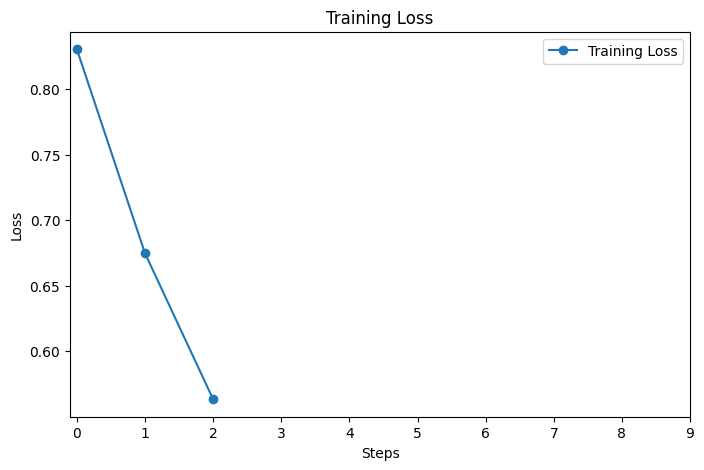

In [2]:
import matplotlib.pyplot as plt

# Get training logs from trainer state
metrics = trainer.state.log_history

# Extract training loss values
train_loss = [x["loss"] for x in metrics if "loss" in x]

if train_loss:
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, label="Training Loss", marker="o")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.xticks(range(10))  # Set x-axis from 0 to 9
    plt.legend()
    plt.show()
else:
    print("No training loss data found in trainer logs.")


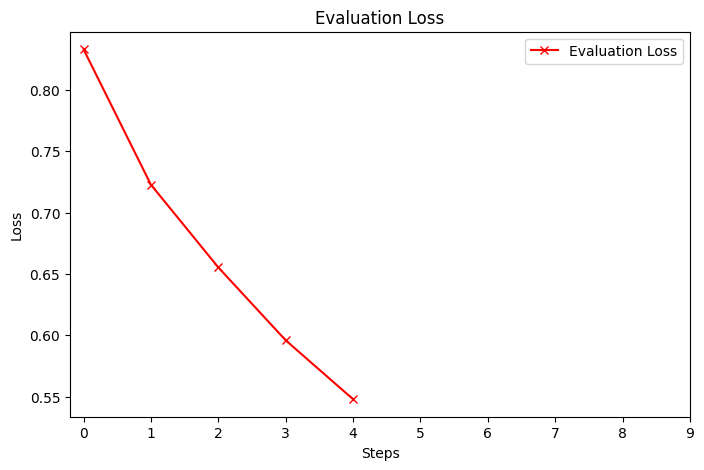

In [3]:
import matplotlib.pyplot as plt

# Get training logs from trainer state
metrics = trainer.state.log_history

# Extract evaluation loss values
eval_loss = [x["eval_loss"] for x in metrics if "eval_loss" in x]

if eval_loss:
    plt.figure(figsize=(8, 5))
    plt.plot(eval_loss, label="Evaluation Loss", marker="x", color="red")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Evaluation Loss")
    plt.xticks(range(10))  # Set x-axis from 0 to 9
    plt.legend()
    plt.show()
else:
    print("No evaluation loss data found in trainer logs.")


In [ ]:
wer_scores = [x["eval_wer"] for x in trainer.state.log_history if "eval_wer" in x]

if wer_scores:
    plt.plot(wer_scores, label="WER", marker="o", color="red")
    plt.xlabel("Steps")
    plt.ylabel("WER")
    plt.title("Word Error Rate Over Training")
    plt.legend()
    plt.show()
else:
    print("No WER data found.")


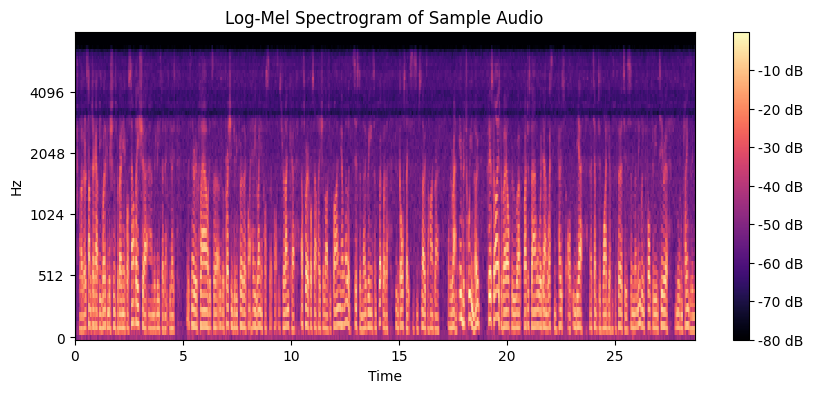

In [7]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Reload original dataset
raw_metadata = pd.read_csv(metadata_path, encoding="ISO-8859-1")

#raw_metadata = pd.read_csv(metadata_path)
raw_metadata['Audio File'] = raw_metadata['Audio File'].apply(lambda x: os.path.join(audio_dir, x))

# Load a sample audio file (first entry)
sample_path = raw_metadata.iloc[0]["Audio File"]
audio_array, sr = librosa.load(sample_path, sr=16000)

# Convert to Mel Spectrogram
mel_spec = librosa.feature.melspectrogram(y=audio_array, sr=sr, n_mels=80)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

# Plot spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spec, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Log-Mel Spectrogram of Sample Audio")
plt.show()
